In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
from matplotlib import cm
import matplotlib.image as mpimg
%matplotlib inline
import scipy.optimize
import numpy as np

Die CSV-Datei enthält für jede Blendenposition ein Zeile.
Aus den Abbildungen der Blende wurden die Spalten 'x-pos' und 'y-pos' gewonnen.
Alle weiteren Spalten sind aus den SR-EELs Abbildungen bestimmt worden.
Dazu wurde jedes Spektrum in 9 gleich große Energieintervalle eingeteilt und diese separat ausgewertet.
Pro Energieintervall wurden die Position ``posXX``, die Breite ``widthXX`` und die Intensität ``intXX`` bestimmt.

In [2]:
data = pd.read_csv('data/SR-EELS_Charakterisierung_410px_Li.csv')

colors = plt.get_cmap('Vega20', lut=len(data))

Das erste Diagramm zeigt die Mittelpunkte der Blendenpositionen.
Diese werden mit der Superposition der 15 einzelbilder überlagert.
Die Mittelpukte verlaufen auf einer Achse, die durch eine Gerade beschreiben wird.
Die gerade wird als ``f(y)`` definiert, da dies die weitere Auswertung erleichtert.

Geradengleichung: f(y) = 0.07 * y + 1901


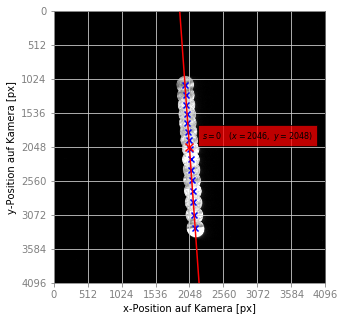

In [3]:
x_pos = data['x-pos']
y_pos = data['y-pos']

lin_func = lambda y, m, b: m * y + b
popt, pcov = scipy.optimize.curve_fit(lin_func, y_pos, x_pos, p0=(1, 0))
print('Geradengleichung: f(y) = %.2f * y + %.0f' % (*popt,))
y_fit = np.linspace(0, 4096, 1000)
x_fit = [lin_func(y, *popt) for y in y_fit]

img = mpimg.imread('data/SR-EELS_Blenden-Superposition.png')

plt.figure(figsize=(5, 5))
plt.xlabel('x-Position auf Kamera [px]')
plt.ylabel('y-Position auf Kamera [px]')
plt.xticks(range(0, 4097, 512))
plt.yticks(range(0, 4097, 512))
plt.imshow(img, cmap='gray')
plt.scatter(x_pos, y_pos, marker='x', c='blue')
plt.plot(x_fit, y_fit, c='red')
# Für die folgende Auswertung wird der Punkt ``s=0`` auf der Geraden definiert.
plt.scatter(lin_func(2048, *popt), 2048, marker='x', c='r', s=64, linewidths=2)
plt.text(lin_func(2048, *popt) + 192,
         2048 - 128,
         '$s=0\quad (x=%d,\ y=2048)$' % lin_func(2048, *popt),
         fontsize=8,
         bbox=dict(facecolor='red', alpha=0.75)
        )
plt.xlim(0, 4096)
plt.ylim(4096, 0)
''' Würde ich kein Hintergrundbild nutzen, dann müsste ich die y-Achse selber invertieren:
limit = plt.ylim()
plt.ylim(limit[1], limit[0])
plt.xlim(limit)
'''
plt.savefig('Bilder/SR-EELS_Charakterisierung_Blenden-Pos')
plt.show()

In [4]:
bogen_func = lambda x, m, b: np.sqrt(1 + m**2)*x
s_0 = bogen_func(2048, *popt)
s = lambda x: bogen_func(x, *popt) - s_0 + 2048
s_pos = [s(y) for y in y_pos]
def offset_pos(pos_list):
    return [pos - 2048 for pos in pos_list]

Die Position des SSR-EEL Spektrums wird gegen die Position der Blende auf der zuvor definierten Geraden aufgetragen.
Es werde nur 3 der 9 untersuchten Energieintervalle genutzt, damit das Diagramm nicht unübersichtlich wird.
Ein linearer Fit soll zeigen, dass es keinen linearen Zusammenhang gibt.

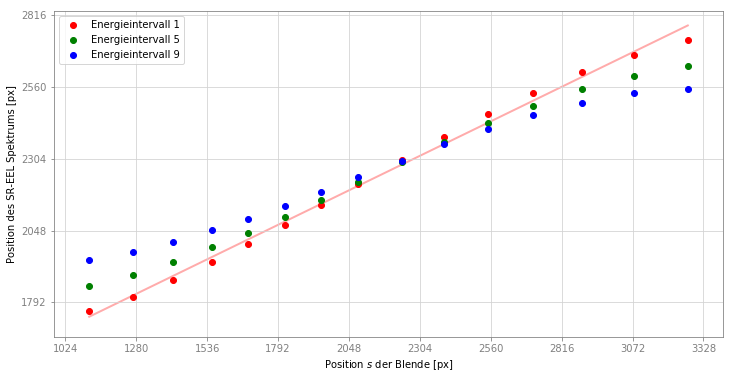

In [5]:
pos10 = data.pos10
pos50 = data.pos50
pos90 = data.pos90

popt, pcov = scipy.optimize.curve_fit(lin_func, s_pos, pos10, p0=(1, 0))
x_fit = np.linspace(np.min(s_pos), np.max(s_pos), 1000)
y_fit = [lin_func(x, *popt) for x in x_fit]

plt.figure(figsize=(12, 6))
plt.xticks(range(0, 4097, 256))
plt.yticks(range(0, 4097, 256))
plt.xlabel('Position $s$ der Blende [px]')
plt.ylabel('Position des SR-EEL Spektrums [px]')
plt.scatter(s_pos, pos10, c='r', edgecolor='r', label='Energieintervall 1')
plt.scatter(s_pos, pos50, c='g', edgecolor='g', label='Energieintervall 5')
plt.scatter(s_pos, pos90, c='b', edgecolor='b', label='Energieintervall 9')
fit_line = plt.plot(x_fit, y_fit, c='r', linewidth=2, zorder=-1, alpha=0.33)
plt.legend(loc='best')
plt.savefig('/home/michael/git/Dissertation/LaTeX_main/Bilder/SR-EELS_Charakterisierung_Pos-vs-s')
plt.show()

pos10_diff = [abs(val - lin_func(x, *popt)) for val, x in zip(pos10, s_pos)]

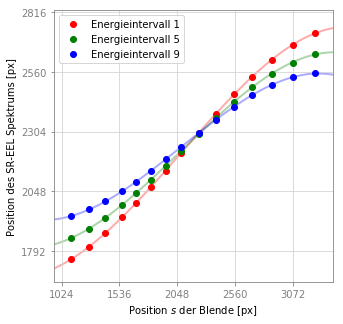

In [6]:
poly3_func = lambda x, a, b, c, d: a*x**3 + b*x**2 + c*x + d

plt.figure(figsize=(5, 5))
plt.xticks(range(0, 4097, 512))
plt.yticks(range(0, 4097, 256))
plt.xlabel('Position $s$ der Blende [px]')
plt.ylabel('Position des SR-EEL Spektrums [px]')
x_lims = None
for y_data, i, c in zip([pos10, pos50, pos90], [1, 5, 9], ['r', 'g', 'b']):
    label = 'Energieintervall %d' % (i,)
    plt.scatter(s_pos, y_data, c=c, edgecolor=c, label=label)
    if not x_lims:
        x_lims = plt.xlim()
    popt, pcov = scipy.optimize.curve_fit(poly3_func, s_pos, y_data, p0=(1, 1, 1, 1))
    x_fit = np.linspace(*x_lims, 1000)
    y_fit = [poly3_func(x, *popt) for x in x_fit]
    plt.plot(x_fit, y_fit, c=c, linewidth=2, zorder=-1, alpha=0.33)
plt.xlim(x_lims)
plt.legend(loc='best')
plt.savefig('Bilder/SR-EELS_Charakterisierung_Pos-vs-s_poly')
plt.show()

Die maximale Abweichung beträgt beim Polynom 1.861 px.


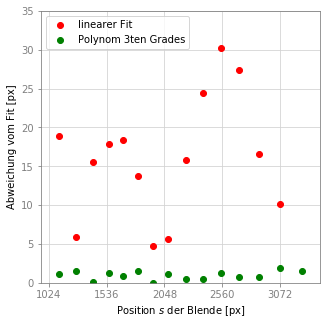

In [7]:
popt, pcov = scipy.optimize.curve_fit(poly3_func, s_pos, pos10, p0=(1, 1, 1, 1))
pos10_diff_poly = [abs(val - poly3_func(x, *popt)) for val, x in zip(pos10, s_pos)]

print('Die maximale Abweichung beträgt beim Polynom %.3f px.' % (np.max(pos10_diff_poly),))

plt.figure(figsize=(5, 5))
plt.xticks(range(0, 4097, 512))
plt.ylim(0, 35)
plt.xlabel('Position $s$ der Blende [px]')
plt.ylabel('Abweichung vom Fit [px]')
plt.scatter(s_pos, pos10_diff, c='r', edgecolor='r', label='linearer Fit')
plt.scatter(s_pos, pos10_diff_poly, c='g', edgecolor='g', label='Polynom 3ten Grades')
plt.legend(loc='upper left')
plt.savefig('Bilder/SR-EELS_Charakterisierung_Pos-vs-s_diff')
plt.show()

Als nächstes wird die Position der SR-EEL Spektren in Abhängigkeit vom Einergieverlust aufgetragen. Als xlabel wird der Index des Energieintervalls angezeigt. Zu jedem Spektrum wird ein linearer Fit durchgeführt und angezeigt.

Da der Datensatz neben den Spalten mit der Position noch weitere Daten enthält, müssen wir die Daten filtern.
Anschließend können wir die einzelnen Zeilen extrahieren.

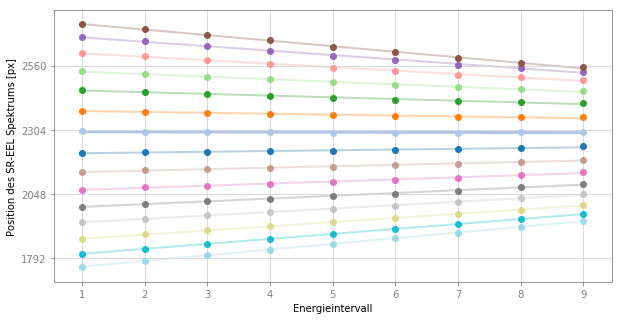

In [8]:
pos_key_list = [key for key in data.keys() if 'pos' in key and not '-pos' in key]
pos_from_keys = [int(key.replace('pos', '')) for key in pos_key_list]
#print(pos_from_keys)
data_pos = data.filter(regex=r'pos\d{2}')
def get_line(i, key_list, data):
    line = []
    for key in key_list:
        line.append(data.iloc[i,][key])
    return line
lines_pos = [get_line(i, pos_key_list, data_pos) for i in range(len(data_pos))]

plt.figure(figsize=(10, 5))
# Bei den xticks verwende ich Indizes statt die Prozent-Werte:
xticks = range(10, 100, 10)
plt.xticks(xticks, ['%d' % (tick / 10,) for tick in xticks])
plt.yticks(range(0, 4097, 256))
plt.xlabel('Energieintervall')
plt.ylabel('Position des SR-EEL Spektrums [px]')

for index, line, in enumerate(lines_pos):
    color = colors(index)
    plt.scatter(pos_from_keys, line, c=color, edgecolor=color)
    popt, pcov = scipy.optimize.curve_fit(lin_func, pos_from_keys, line, p0=(1, 0))
    x_fit = np.linspace(np.min(pos_from_keys), np.max(pos_from_keys), 1000)
    y_fit = [lin_func(x, *popt) for x in x_fit]
    if index == 1:
        a = 1
        lw = 3
    else:
        a = 0.33
        lw = 2
    plt.plot(x_fit, y_fit, c=color, linewidth=lw, zorder=-1, alpha=a)
plt.savefig('Bilder/SR-EELS_Charakterisierung_Pos-vs-E')
plt.show()

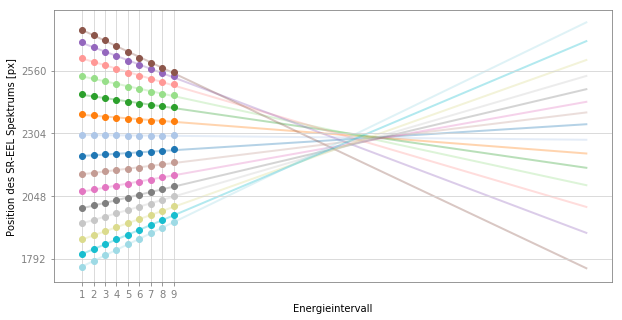

In [9]:
plt.figure(figsize=(10, 5))
# Bei den xticks verwende ich Indizes statt die Prozent-Werte:
xticks = range(10, 100, 10)
plt.xticks(xticks, ['%d' % (tick / 10,) for tick in xticks])
plt.yticks(range(0, 4097, 256))
plt.xlabel('Energieintervall')
plt.ylabel('Position des SR-EEL Spektrums [px]')

for index, line, in enumerate(lines_pos):
    color = colors(index)
    plt.scatter(pos_from_keys, line, c=color, edgecolor=color)
    popt, pcov = scipy.optimize.curve_fit(lin_func, pos_from_keys, line, p0=(1, 0))
    x_fit = np.linspace(np.min(pos_from_keys), 5 * np.max(pos_from_keys), 1000)
    y_fit = [lin_func(x, *popt) for x in x_fit]
    if index == 1:
        a = 1
        lw = 3
    else:
        a = 0.33
        lw = 2
    plt.plot(x_fit, y_fit, c=color, linewidth=2, zorder=-1, alpha=0.33)
plt.savefig('Bilder/SR-EELS_Charakterisierung_Pos-vs-E_p1')
plt.show()

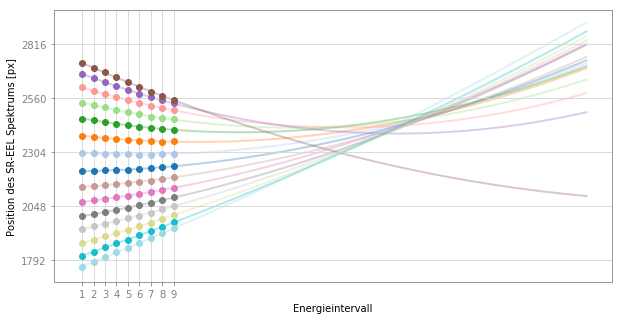

In [10]:
plt.figure(figsize=(10, 5))
# Bei den xticks verwende ich Indizes statt die Prozent-Werte:
xticks = range(10, 100, 10)
plt.xticks(xticks, ['%d' % (tick / 10,) for tick in xticks])
plt.yticks(range(0, 4097, 256))
plt.xlabel('Energieintervall')
plt.ylabel('Position des SR-EEL Spektrums [px]')

poly2_func = lambda x, a, b, c: a + b*x + c*x**2

for index, line, in enumerate(lines_pos):
    color = colors(index)
    plt.scatter(pos_from_keys, line, c=color, edgecolor=color)
    popt, pcov = scipy.optimize.curve_fit(poly2_func, pos_from_keys, line, p0=(1, 1, 1))
    x_fit = np.linspace(np.min(pos_from_keys), 5 * np.max(pos_from_keys), 1000)
    y_fit = [poly2_func(x, *popt) for x in x_fit]
    if index == 1:
        a = 1
        lw = 3
    else:
        a = 0.33
        lw = 2
    plt.plot(x_fit, y_fit, c=color, linewidth=2, zorder=-1, alpha=0.33)
plt.savefig('Bilder/SR-EELS_Charakterisierung_Pos-vs-E_p2')
plt.show()

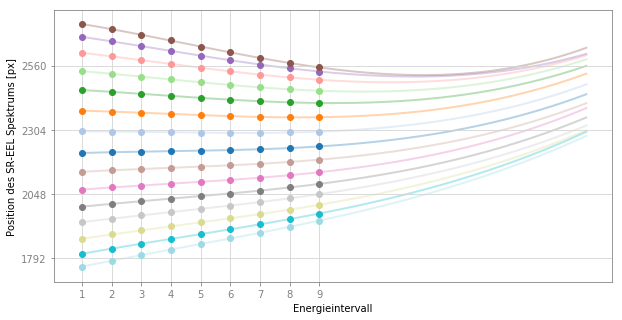

In [11]:
plt.figure(figsize=(10, 5))
# Bei den xticks verwende ich Indizes statt die Prozent-Werte:
xticks = range(10, 100, 10)
plt.xticks(xticks, ['%d' % (tick / 10,) for tick in xticks])
plt.yticks(range(0, 4097, 256))
plt.xlabel('Energieintervall')
plt.ylabel('Position des SR-EEL Spektrums [px]')

for index, line, in enumerate(lines_pos):
    color = colors(index)
    plt.scatter(pos_from_keys, line, c=color, edgecolor=color)
    popt, pcov = scipy.optimize.curve_fit(poly3_func, pos_from_keys, line, p0=(1, 1, 1, 1))
    x_fit = np.linspace(np.min(pos_from_keys), 2 * np.max(pos_from_keys), 1000)
    y_fit = [poly3_func(x, *popt) for x in x_fit]
    if index == 1:
        a = 1
        lw = 3
    else:
        a = 0.33
        lw = 2
    plt.plot(x_fit, y_fit, c=color, linewidth=2, zorder=-1, alpha=0.33)
plt.savefig('Bilder/SR-EELS_Charakterisierung_Pos-vs-E_p3')
plt.show()

Als nächstes wird die Breite der einzelnen Spektren betrachtet.
Beim ersten Diagramm werden nur die Energieintervalle 1, 5 und 9 angezeigt.

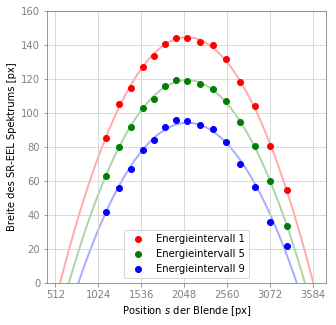

In [12]:
width10 = data.width10
width50 = data.width50
width90 = data.width90

plt.figure(figsize=(5, 5))
plt.xticks(range(0, 4097, 512))
plt.yticks(range(0, 200, 20))
plt.ylim(0, 160)
plt.xlabel('Position $s$ der Blende [px]')
plt.ylabel('Breite des SR-EEL Spektrums [px]')

plt.scatter(s_pos, width10, c='r', edgecolor='r', label='Energieintervall 1')
plt.scatter(s_pos, width50, c='g', edgecolor='g', label='Energieintervall 5')
plt.scatter(s_pos, width90, c='b', edgecolor='b', label='Energieintervall 9')

poly2_func = lambda x, a, b, c: a*x**2 + b*x + c
for width, c in zip([width10, width50, width90], ['r', 'g', 'b']):
    popt, pcov = scipy.optimize.curve_fit(poly2_func, s_pos, width, p0=(-1, 1, 150))
    x_fit = np.linspace(0, 4096, 1000)
    y_fit = [poly2_func(x, *popt) for x in x_fit]
    xs = []
    ys = []
    for i, val in enumerate(y_fit):
        if val >= -1:
            xs.append(x_fit[i])
            ys.append(val)
    plt.plot(xs, ys, c=c, linewidth=2, zorder=-1, alpha=0.33)

plt.legend(loc='lower center')
plt.savefig('Bilder/SR-EELS_Charakterisierung_Width-vs-s')
plt.show()

Es ist außerdem von Interesse, wie sich die Breite mit der Position des SR-EEL Spektrum verändert.
Es werden nur die x-Werte verändert.

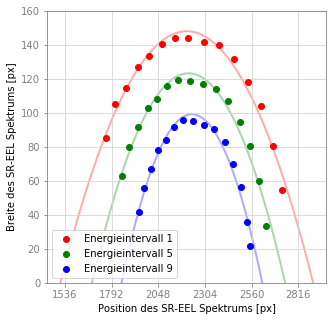

In [13]:
plt.figure(figsize=(5, 5))
plt.xticks(range(0, 4097, 256))
plt.yticks(range(0, 200, 20))
plt.ylim(0, 160)
plt.xlabel('Position des SR-EEL Spektrums [px]')
plt.ylabel('Breite des SR-EEL Spektrums [px]')

plt.scatter(pos10, width10, c='r', edgecolor='r', label='Energieintervall 1')
plt.scatter(pos50, width50, c='g', edgecolor='g', label='Energieintervall 5')
plt.scatter(pos90, width90, c='b', edgecolor='b', label='Energieintervall 9')

# Da die x-Werte vom Energieintervall abhängen, müssen wir zusätzlich über diese Iterieren:
for pos, width, c in zip([pos10, pos50, pos90], [width10, width50, width90], ['r', 'g', 'b']):
    popt, pcov = scipy.optimize.curve_fit(poly2_func, pos , width, p0=(-1, 1, 150))
    x_fit = np.linspace(0, 4096, 1000)
    y_fit = [poly2_func(x, *popt) for x in x_fit]
    xs = []
    ys = []
    for i, val in enumerate(y_fit):
        if val >= -2:
            xs.append(x_fit[i])
            ys.append(val)
    plt.plot(xs, ys, c=c, linewidth=2, zorder=-1, alpha=0.33)

plt.legend(loc='lower left')
plt.savefig('Bilder/SR-EELS_Charakterisierung_Width-vs-Pos')
plt.show()

Der nächste Graph ist etwas problematisch, da wir die Breite gegen den Energieverlust auftragen.
Da das Spektrum die L-Kanten von Silizium enthält, resultiert daraus eine Schwankung der Breite.
Eine Tendenz lässt sich trotzdem erkennen: Die Breite sinkt mit steigendem Energieverlust.

Da der Datensatz neben den Spalten mit der Breite noch weitere Daten enthält, müssen wir die Daten filtern.
Anschließend können wir die einzelnen Zeilen extrahieren.

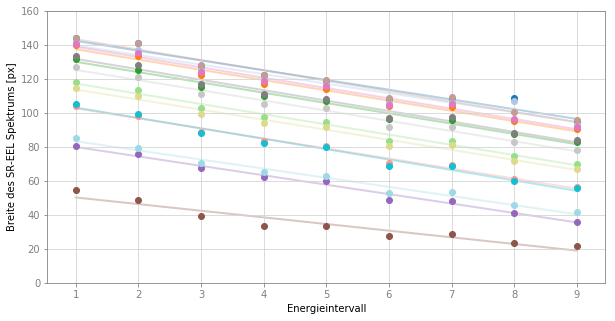

In [14]:
width_key_list = [key for key in data.keys() if 'width' in key]
pos_from_keys = [int(key.replace('width', '')) for key in width_key_list]
# Wir benötigen nur die Spalten, die die Breite enthalten:
data_width = data.filter(regex=r'width\d{2}')
lines_width = [get_line(i, width_key_list, data_width) for i in range(len(data_width))]

plt.figure(figsize=(10, 5))
# Bei den xticks verwende ich Indizes statt die Prozent-Werte:
xticks = range(10, 100, 10)
plt.xticks(xticks, ['%d' % (tick / 10,) for tick in xticks])
plt.yticks(range(0, 200, 20))
plt.ylim(0, 160)
plt.xlabel('Energieintervall')
plt.ylabel('Breite des SR-EEL Spektrums [px]')

for index, line, in enumerate(lines_width):
    color = colors(index)
    plt.scatter(pos_from_keys, line, c=color, edgecolor=color)
    popt, pcov = scipy.optimize.curve_fit(lin_func, pos_from_keys , line, p0=(-1, 1))
    x_fit = np.linspace(np.min(pos_from_keys), np.max(pos_from_keys), 1000)
    y_fit = [lin_func(x, *popt) for x in x_fit]
    plt.plot(x_fit, y_fit, c=color, linewidth=2, zorder=-1, alpha=0.33)
plt.savefig('Bilder/SR-EELS_Charakterisierung_Width-vs-E')
plt.show()

Die Intensität sollte konstant bleiben, wenn man sie aufträgt.
Bis auf einen ausreißer ist dies in etwa der Fall.

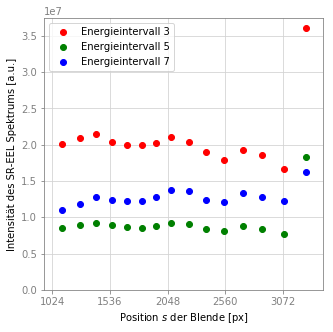

In [15]:
int30 = data.int30
int50 = data.int50
int70 = data.int70

plt.figure(figsize=(5, 5))
plt.xticks(range(0, 4097, 512))
plt.xlabel('Position $s$ der Blende [px]')
plt.ylabel('Intensität des SR-EEL Spektrums [a.u.]')

plt.scatter(s_pos, int30, c='r', edgecolor='r', label='Energieintervall 3')
plt.scatter(s_pos, int50, c='g', edgecolor='g', label='Energieintervall 5')
plt.scatter(s_pos, int70, c='b', edgecolor='b', label='Energieintervall 7')
plt.ylim(ymin=0)

plt.legend(loc='upper left')
plt.savefig('Bilder/SR-EELS_Charakterisierung_Int-vs-s')
plt.show()

[  -4.53057152  951.42719756]
[  -2.45111544  465.60187632]
[  -4.57408003  770.87127701]


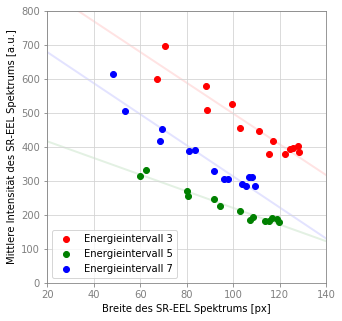

In [16]:
mean30 = data.mean30
mean50 = data.mean50
mean70 = data.mean70

plt.figure(figsize=(5, 5))
plt.xlabel('Breite des SR-EEL Spektrums [px]')
plt.ylabel('Mittlere Intensität des SR-EEL Spektrums [a.u.]')
plt.xlim(20, 140)
plt.ylim(0, 800)

width30 = data.width30
width50 = data.width50
width70 = data.width70
plt.scatter(width30, mean30, c='r', edgecolor='r', label='Energieintervall 3')
plt.scatter(width50, mean50, c='g', edgecolor='g', label='Energieintervall 5')
plt.scatter(width70, mean70, c='b', edgecolor='b', label='Energieintervall 7')

for width, mean, c in zip([width30, width50, width70], [mean30, mean50, mean70], ['r', 'g', 'b']):
    xs = []
    ys = []
    for i, val in enumerate(mean):
        if val < 1000:
            xs.append(width[i])
            ys.append(val)
    popt, pcov = scipy.optimize.curve_fit(lin_func, xs, ys, p0=(-5, 900))
    print(popt)
    x_fit = np.linspace(20, 140, 1000)
    y_fit = [lin_func(x, *popt) for x in x_fit]
    plt.plot(x_fit, y_fit, c=c, linewidth=2, zorder=-1, alpha=0.11)

plt.legend(loc='lower left')
plt.savefig('Bilder/SR-EELS_Charakterisierung_Int-vs-Width')
plt.show()

Trägt man die Intensität gegen den Energieverlust auf, so erkennt man den potenzförmigen untergrund und die L-Kanten von Silizium.
Auch bei dieser Darstellung sticht ein Datensatz hervor.
Alle anderen Datensätze scheinnen nur statistischen Schwankungen zu unterliegen.

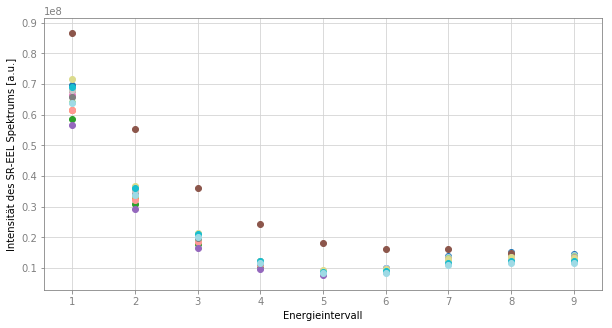

In [17]:
int_key_list = [key for key in data.keys() if 'int' in key]
int_from_keys = [int(key.replace('int', '')) for key in int_key_list]
data_int = data.filter(regex=r'int\d{2}')
lines_int = [get_line(i, int_key_list, data_int) for i in range(len(data_int))]

plt.figure(figsize=(10, 5))
# Bei den xticks verwende ich Indizes statt die Prozent-Werte:
xticks = range(10, 100, 10)
plt.xticks(xticks, ['%d' % (tick / 10,) for tick in xticks])
plt.xlabel('Energieintervall')
plt.ylabel('Intensität des SR-EEL Spektrums [a.u.]')

for index, line, in enumerate(lines_int):
    color = colors(index)
    plt.scatter(int_from_keys, line, marker='o', c=color, edgecolor=color)
plt.savefig('Bilder/SR-EELS_Charakterisierung_Int-vs-E')
plt.show()

Statt dem zuletzt gezeigten Scatter-Plot kann man auch einen Boxplot verwenden.

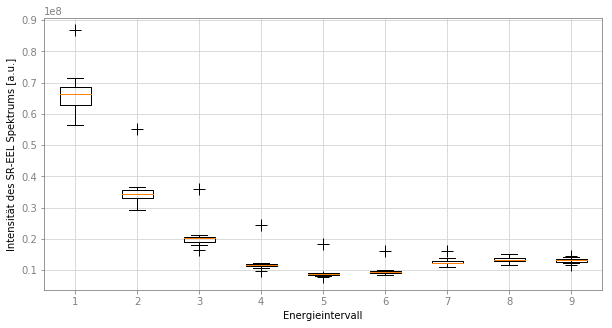

In [18]:
keys = list(data_int.keys())
keys.sort()
data_list = [data_int[key] for key in keys]

plt.figure(figsize=(10, 5))
# Bei den xticks verwende ich Indizes statt die Prozent-Werte:
xticks = range(10, 100, 10)
plt.xticks(xticks, ['%d' % (tick / 10,) for tick in xticks])
plt.xlabel('Energieintervall')
plt.ylabel('Intensität des SR-EEL Spektrums [a.u.]')

plt.boxplot(data_list, flierprops=dict(marker='+', markersize=12))
plt.savefig('Bilder/SR-EELS_Charakterisierung_Int-vs-E_Boxplot')
plt.show()

Wie die Auswertung funktioniert, das zeige ich an einem Beispielbild.

Hier in Jupyter sieht es so aus, als ob die Kreuze nach unten verschoben sind.
In der PDF-Datei ist dies nicht, bzw. nur minimal der Fall.

Im Notebook liegen die Punkte nicht dort, wo man sie im exportierten Bild sieht.


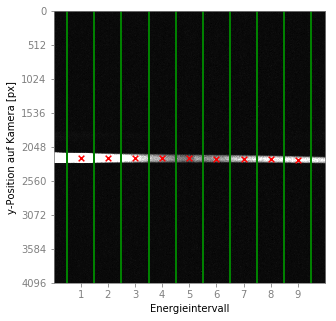

In [19]:
img = mpimg.imread('data/SR-EELS_Charakterisierung_Pos1.png')

plt.figure(figsize=(5, 5))
plt.grid()
# Bei den xticks verwende ich Indizes statt die Prozent-Werte:
xticks = range(409, 4090, 409)
plt.xticks(xticks, ['%d' % (tick / 409,) for tick in xticks])
plt.xlabel('Energieintervall')
plt.ylabel('y-Position auf Kamera [px]')
plt.yticks(range(0, 4097, 512))
plt.imshow(img, cmap='gray')

for i in range(1,11):
    l = mlines.Line2D([i * 409 - 409/2]*2, [0, 4095], c='g', linewidth=2)
    ax = plt.gca()
    ax.add_line(l)

# Anders als weiter oben lassen sich die Werte nicht in der Richtigen eihenfolge plotten.
# Ich muss deshalb die Listen sortieren, was zu keiner falschen Zuordnung von x- und y-Paaren führen sollte.
x_pos = [pos * 40.9 for pos in pos_from_keys]
x_pos.sort()
y_pos = [pos for pos in lines_pos[0]]
y_pos.sort()
plt.scatter(x_pos, y_pos, s=32, marker='x', c='r', linewidths=2)

plt.savefig('Bilder/SR-EELS_Charakterisierung_Energieintervalle')
print('Im Notebook liegen die Punkte nicht dort, wo man sie im exportierten Bild sieht.')
plt.show()

In [20]:
df_sorted = data.sort_values(by='y-pos', inplace=False).sort_index(axis=1)
df_sorted.filter(regex='pos')

,pos10,pos20,pos30,pos40,pos50,pos60,pos70,pos80,pos90,x-pos,y-pos
14,1759.669,1783.256,1805.640,1827.584,1849.838,1871.823,1894.637,1917.954,1943.027,1978.753,1112.722
13,1810.859,1831.440,1851.091,1870.033,1888.782,1908.412,1928.031,1948.854,1971.082,1989.392,1270.636
12,1870.565,1887.799,1903.946,1919.835,1935.761,1951.849,1968.842,1986.553,2005.915,1999.595,1414.518
11,1936.695,1950.811,1963.818,1976.538,1989.656,2002.569,2016.752,2031.800,2048.183,2010.425,1556.545
10,1998.333,2009.810,2020.110,2030.149,2040.522,2050.764,2062.514,2074.786,2089.037,2018.191,1685.836
9,2066.481,2075.035,2082.487,2090.308,2096.907,2104.471,2114.217,2123.897,2135.477,2029.073,1817.698
8,2137.493,2143.116,2148.433,2153.152,2157.727,2163.173,2169.094,2176.596,2185.638,2038.683,1946.204
0,2212.468,2215.169,2217.617,2219.410,2221.193,2224.031,2227.217,2231.439,2238.478,2061.788,2080.467
1,2298.346,2297.770,2296.384,2294.870,2293.421,2292.164,2292.346,2294.002,2297.215,2064.495,2237.598
2,2380.907,2376.942,2372.378,2368.127,2362.816,2358.731,2355.672,2354.318,2354.723,2074.554,2390.985
